## Загрузка данных

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, losses, metrics
from tensorflow.keras.callbacks import EarlyStopping

# Убедимся, что используем GPU (если доступен)
print("GPU доступен:", len(tf.config.list_physical_devices('GPU')) > 0)

# Загрузка CIFAR-10
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# CIFAR-10: 50k train, 10k test, изображения 32×32×3 (RGB)
print("x_train.shape:", x_train.shape)  # (50000, 32, 32, 3)
print("y_train.shape:", y_train.shape)  # (50000, 1)

# Преобразуем метки в 1D-массив (удаляем лишнюю ось)
y_train = y_train.flatten()
y_test = y_test.flatten()

# Нормализация: приводим пиксели [0,255] → [0,1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Разделение train → train + val (90%/10%)
split_idx = int(0.9 * len(x_train))
x_train_split, x_val = x_train[:split_idx], x_train[split_idx:]
y_train_split, y_val = y_train[:split_idx], y_train[split_idx:]

print(f"Train: {x_train_split.shape}, Val: {x_val.shape}, Test: {x_test.shape}")


GPU доступен: False
x_train.shape: (50000, 32, 32, 3)
y_train.shape: (50000, 1)
Train: (45000, 32, 32, 3), Val: (5000, 32, 32, 3), Test: (10000, 32, 32, 3)


## Построение 3х моделей: Обычной CNN, CNN с dropout и CNN с batch normalization 

In [9]:
def create_baseline():
    inputs = layers.Input(shape=(32, 32, 3))
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    outputs = layers.Dense(10, activation='softmax')(x)
    return models.Model(inputs, outputs, name="Baseline")

def create_dropout():
    inputs = layers.Input(shape=(32, 32, 3))
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)  # регуляризация
    outputs = layers.Dense(10, activation='softmax')(x)
    return models.Model(inputs, outputs, name="Dropout")

def create_batchnorm():
    inputs = layers.Input(shape=(32, 32, 3))
    x = layers.Conv2D(32, 3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)  # нормализация до активации
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(512)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    outputs = layers.Dense(10, activation='softmax')(x)
    return models.Model(inputs, outputs, name="BatchNorm")

# Создаём модели
models_dict = {
    "Baseline": create_baseline(),
    "Dropout": create_dropout(),
    "BatchNorm": create_batchnorm()
}

# Выведем архитектуру одной модели (например, Baseline)
models_dict["Baseline"].summary()

Model: "Baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,122,186 (8.10 MB)

 Trainable params: 2,122,186 (8.10 MB)

 Non-trainable params: 0 (0.00 B)

## Обучение всех моделей

In [ ]:
EPOCHS = 20
BATCH_SIZE = 64
LEARNING_RATE = 0.001

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    mode='min',          # ← Минимизируем ошибку
    min_delta=0.001      # ← Минимальное улучшение
)

history_dict = {}
trained_models = {}  # Для сохранения обученных моделей

for name in ["Baseline", "Dropout", "BatchNorm"]:  # Проходим по именам
    print(f"\n{'='*60}")
    print(f"Обучаем модель: {name}")
    print('='*60)
    
    # СОЗДАЁМ НОВУЮ МОДЕЛЬ КАЖДЫЙ РАЗ!
    if name == "Baseline":
        model = create_baseline()
    elif name == "Dropout":
        model = create_dropout()
    else:  # BatchNorm
        model = create_batchnorm()
    
    # Компиляция
    model.compile(
        optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
        loss=losses.SparseCategoricalCrossentropy(),
        metrics=[metrics.SparseCategoricalAccuracy()]
    )
    
    # Обучение
    history = model.fit(
        x_train_split, y_train_split,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(x_val, y_val),
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Сохраняем результаты
    history_dict[name] = history.history
    trained_models[name] = model  # Сохраняем обученную модель
    print(f"  → Завершено на эпохе {len(history.history['val_loss'])}")

# Обновляем словарь моделей
models_dict = trained_models


Обучаем модель: Baseline
Epoch 1/20
352/704 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - loss: 1.8233 - sparse_categorical_accuracy: 0.3402

KeyboardInterrupt: 

## Визуализация результатов обучения

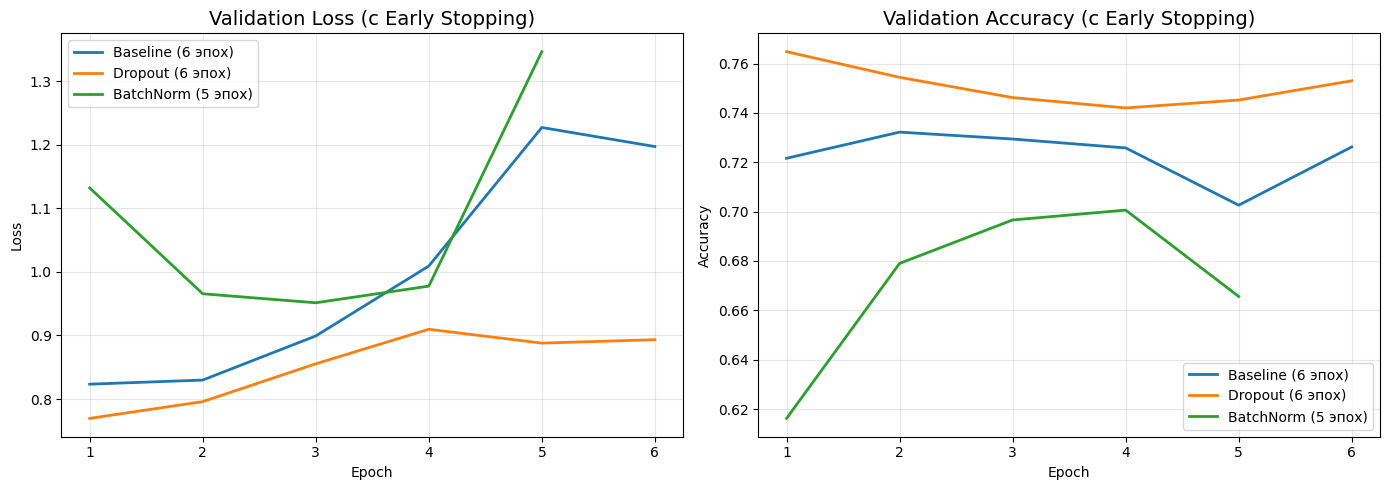

РЕЗУЛЬТАТЫ С EARLY STOPPING:
Baseline     | Эпох:  6 | Лучшая эпоха:  2
             | Train: 83.77% | Val: 73.22% | Разрыв: 10.5%
----------------------------------------------------------------------
Dropout      | Эпох:  6 | Лучшая эпоха:  1
             | Train: 83.32% | Val: 76.48% | Разрыв: 6.8%
----------------------------------------------------------------------
BatchNorm    | Эпох:  5 | Лучшая эпоха:  4
             | Train: 90.71% | Val: 70.06% | Разрыв: 20.6%
----------------------------------------------------------------------


In [8]:
plt.figure(figsize=(14, 5))

# 1. График потерь на валидации
plt.subplot(1, 2, 1)
for name, hist in history_dict.items():
    epochs = range(1, len(hist['val_loss']) + 1)  # Динамическое количество эпох
    plt.plot(epochs, hist['val_loss'], label=f"{name} ({len(epochs)} эпох)", linewidth=2)
    
plt.title('Validation Loss (с Early Stopping)', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. График точности на валидации
plt.subplot(1, 2, 2)
for name, hist in history_dict.items():
    epochs = range(1, len(hist['val_sparse_categorical_accuracy']) + 1)
    plt.plot(epochs, hist['val_sparse_categorical_accuracy'], 
             label=f"{name} ({len(epochs)} эпох)", linewidth=2)
    
plt.title('Validation Accuracy (с Early Stopping)', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



# Таблица результатов с учётом early stopping
print("="*70)
print("РЕЗУЛЬТАТЫ С EARLY STOPPING:")
print("="*70)

for name, hist in history_dict.items():
    # Лучшая точность и эпоха
    best_acc = max(hist['val_sparse_categorical_accuracy'])
    best_epoch = hist['val_sparse_categorical_accuracy'].index(best_acc) + 1
    final_epoch = len(hist['val_sparse_categorical_accuracy'])
    
    # Точность на обучении в лучшую эпоху
    train_acc = hist['sparse_categorical_accuracy'][best_epoch-1]
    
    print(f"{name:12} | Эпох: {final_epoch:2} | Лучшая эпоха: {best_epoch:2}")
    print(f"             | Train: {train_acc:.2%} | Val: {best_acc:.2%} | Разрыв: {(train_acc-best_acc):.1%}")
    print("-"*70)

## Определение лучшей модели по максимальной валидационной точности

In [ ]:
best_model_name = None
best_val_acc = 0.0

for name, hist in history_dict.items():
    max_acc = max(hist['val_sparse_categorical_accuracy'])
    print(f"{name}: лучшая валидационная точность = {max_acc:.4f}")
    if max_acc > best_val_acc:
        best_val_acc = max_acc
        best_model_name = name

print(f"\nЛучшая модель: {best_model_name} (точность: {best_val_acc:.4f})")

Baseline: лучшая валидационная точность = 0.7366
Dropout: лучшая валидационная точность = 0.7540
BatchNorm: лучшая валидационная точность = 0.7064

🏆 Лучшая модель: Dropout (точность: 0.7540)


## Пример предсказания для каждой модели с визуализацией для любого изображения

In [1]:
# Классы для вывода вместо меток
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Возьмём одно изображение 
idx = 7
sample_image = x_test[idx]           # форма: (32, 32, 3)
true_label = y_test[idx]             # целое число: 0–9

plt.figure(figsize=(15, 4))

# Выведем истинное изображение
plt.subplot(1, 4, 1)
plt.imshow(sample_image)
plt.title(f"Истинный класс:\n{classes[true_label]}")
plt.axis('off')

# Предсказание каждой моделью
for i, (name, model) in enumerate(models_dict.items(), start=2):
    # Предсказание: модель ожидает батч → добавляем ось [1, 32, 32, 3]
    pred = model.predict(sample_image[None, ...], verbose=0)
    predicted_class_id = np.argmax(pred)
    confidence = np.max(pred) * 100  # в процентах

    plt.subplot(1, 4, i)
    plt.imshow(sample_image)
    plt.title(f"{name}:\n{classes[predicted_class_id]}\n({confidence:.1f}%)")
    plt.axis('off')

plt.tight_layout()
plt.show()




NameError: name 'x_test' is not defined